# Optimal hard threshold for singular values

This notebook demonstrates the effect of rank-truncation on noise in the data. We show how the automatic estimation of the optimal rank simplifies the truncation. The notebook's content is based on the following two resources, where the first resource is an excellent Pyton-based tutorial on the optimal SVD-HT (SVD Hard Threshold), and the second resource is a research article covering the theory behind the optimal rank selection.

1. Robert Taylor: [Optimal Singular Value Hard Threshold](http://www.pyrunner.com/weblog/2016/08/01/optimal-svht/), PyRunner Webblog, 2016
2. M. Gavish and D. L. Donoho, The Optimal Hard Threshold for Singular Values is $4/\sqrt {3}$, IEEE Transactions on Information Theory, vol. 60, no. 8, pp. 5040-5053, Aug. 2014, doi: [10.1109/TIT.2014.2323359](https://ieeexplore.ieee.org/document/6846297).

In [1]:
import torch as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
from flowtorch.analysis.svd import SVD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Creating the data matrix

The data matrix is assembled from the temporal evolution of a 1D profile with two modes and some added white Gaussian noise.

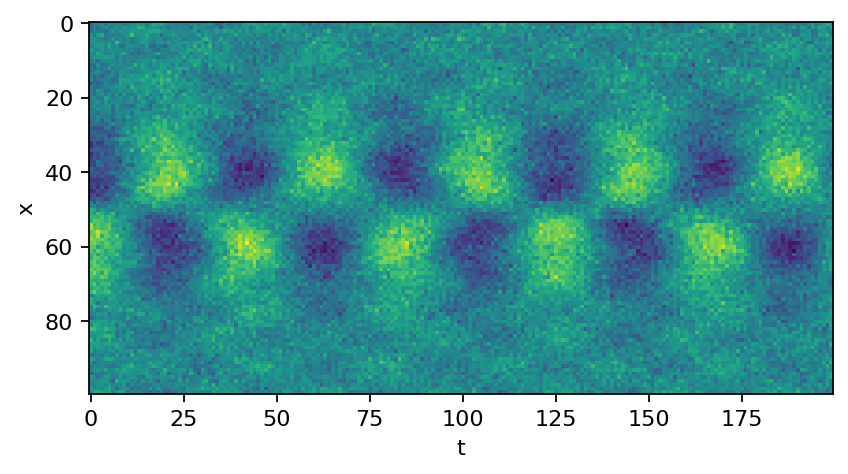

In [2]:
x = pt.linspace(-10, 10, 100)
t = pt.linspace(0, 20, 200)
Xm, Tm = pt.meshgrid(x, t)

data_matrix = 5.0 / pt.cosh(0.5*Xm) * pt.tanh(0.5*Xm) * pt.exp(1.5j*Tm) # primary mode
data_matrix += 0.5 * pt.sin(2.0*Xm) * pt.exp(2.0j*Tm) # secondary mode
data_matrix += 0.5 * pt.normal(mean=pt.zeros_like(Xm), std=pt.ones_like(Xm))

# plot data matrix as image
plt.imshow(data_matrix.real)
plt.xlabel("t")
plt.ylabel("x")
plt.show()

## Singular value decomposition with hard threshold

First, we have a look at the singular value distribution without rank truncation. Since we created the data with two spatial modes, there should be only two singular values different from zero.

In [3]:
svd = SVD(data_matrix, 100)
print(svd)

SVD of a 100x200 data matrix
Selected/optimal rank: 100/2
data type: torch.complex64 (8b)
truncated SVD size: 234.7656Kb


Looking at the SVD meta data, we can see that an optimal threshold of two was estimated, but we chose a rank of 100. Let's plot the singular value distribution and show the optimal truncation.

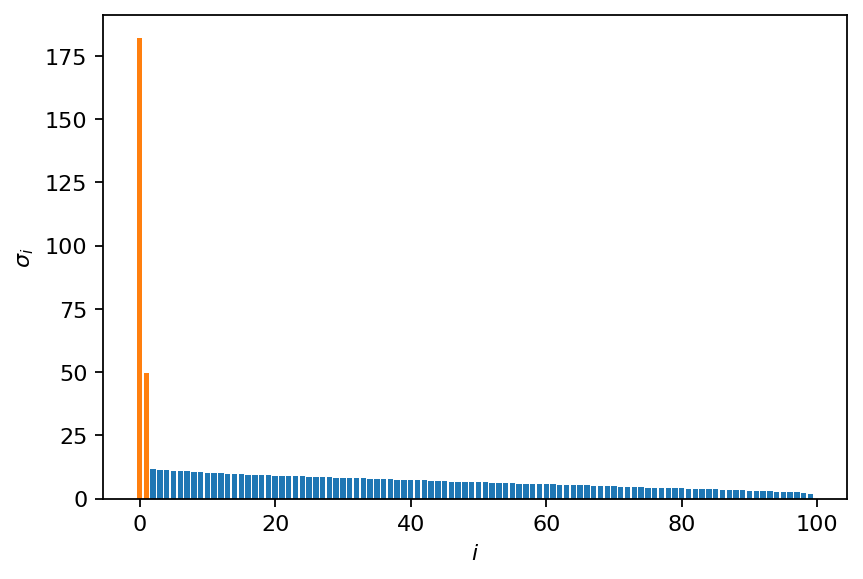

In [4]:
color = ["C0" if s <= svd.s[2] else "C1" for s in svd.s]
plt.bar(range(svd.s.shape[0]), svd.s, color=color)
plt.xlabel(r"$i$")
plt.ylabel(r"$\sigma_i$")
plt.show()

Now we perform the SVD again, but this time with automatic rank trunction. Note that we could also use the previously computed SVD and do the truncation manually. The truncated SVD is significantly smaller than its full counterpart.

In [5]:
svd = SVD(data_matrix)
print(svd)

SVD of a 100x200 data matrix
Selected/optimal rank: 2/2
data type: torch.complex64 (8b)
truncated SVD size: 4.6953Kb


We can now reconstruct the full data based on the truncated SVD. Since we cut off the noisy modes, the SVD acts as a denoising tool in this application.

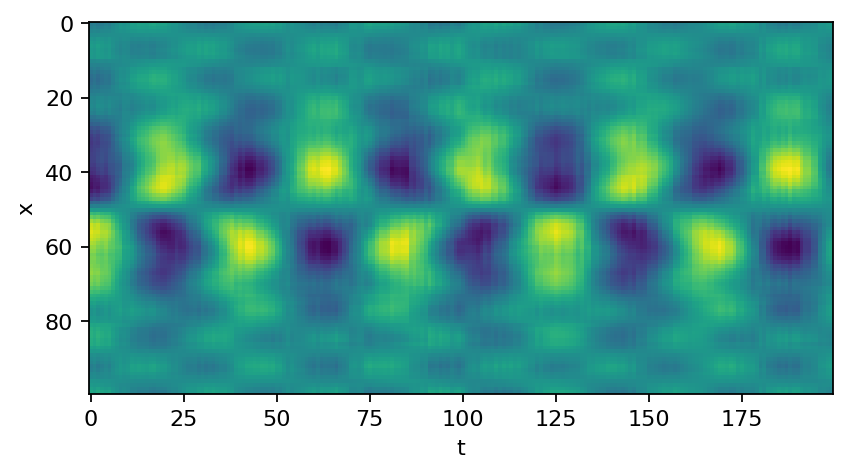

In [6]:
reconstruction = svd.U @ pt.diag(svd.s).type(pt.complex64) @ svd.V.conj().T
plt.imshow(reconstruction.real)
plt.xlabel("t")
plt.ylabel("x")
plt.show()